# Cardiomegaly Detection from Chest X-rays using CNNs and Transfer Learning

In this project, I use deep learning to classify chest X-ray images as:

- **True** – cardiomegaly (enlarged heart)
- **False** – no cardiomegaly

The dataset contains X-ray images that have already been preprocessed and labeled.  
The goal is to:

1. Understand how to work with an image dataset in TensorFlow  
2. Build a **baseline CNN**  
3. Apply **two transfer learning models** (MobileNetV2 and DenseNet121)  
4. Compare their performance using accuracy, loss, confusion matrices, and classification reports  

This notebook follows the Computer Vision presentation guidelines:
- Dataset explanation and sample images  
- Preprocessing steps  
- Baseline model  
- Two transfer learning models  
- Final evaluation and lessons learned  


**Code: Imports & Basic Setup**

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Make results a bit more repeatable
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

print(tf.__version__)

2025-12-05 19:45:54.820023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764963955.046430      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764963955.116153      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2.18.0


In [2]:
# Base directory for the dataset
base_dir = "/kaggle/input/cardiomegaly-disease-prediction-using-cnn"

# In this dataset structure:
# train/train/<class>/
# test/test/<class>/
train_dir = os.path.join(base_dir, "train/train")
test_dir = os.path.join(base_dir, "test/test")

print("Train directory:", train_dir)
print("Test directory:", test_dir)
print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))


Train directory: /kaggle/input/cardiomegaly-disease-prediction-using-cnn/train/train
Test directory: /kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test
Train classes: ['false', 'true']
Test classes: ['false', 'true']


In [3]:
img_size = (224, 224)
batch_size = 32

# Training dataset (80% of images in train_dir)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# Validation dataset (20% of images in train_dir)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 4438 files belonging to 2 classes.
Using 3551 files for training.


2025-12-05 19:47:39.352499: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 4438 files belonging to 2 classes.
Using 887 files for validation.
Class names: ['false', 'true']


In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 1114 files belonging to 2 classes.


**Count Images in Train / Val / Test**

In [5]:
def count_images(ds):
    total = 0
    for batch_images, batch_labels in ds:
        total += batch_images.shape[0]
    return total

num_train = count_images(train_ds)
num_val = count_images(val_ds)
num_test = count_images(test_ds)

print(f"Training images:   {num_train}")
print(f"Validation images: {num_val}")
print(f"Test images:       {num_test}")

Training images:   3551
Validation images: 887
Test images:       1114


**Show Sample Images from Each Class**

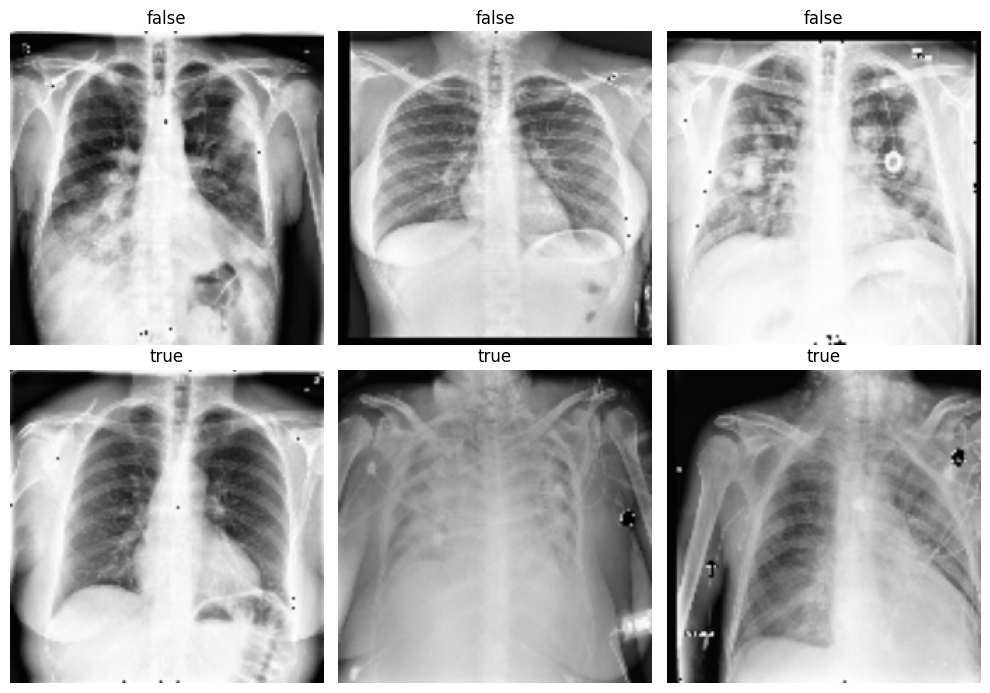

In [6]:
plt.figure(figsize=(10, 7))

# Take one batch from train_ds
for images, labels in train_ds.take(1):
    images_batch = images
    labels_batch = labels.numpy()

# Indices for each class
false_indices = np.where(labels_batch == 0)[0]
true_indices = np.where(labels_batch == 1)[0]

# Pick up to 3 of each
false_indices = false_indices[:3]
true_indices = true_indices[:3]

# First row: false
for i, idx in enumerate(false_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(images_batch[idx].numpy().astype("uint8"), cmap='gray')
    plt.title("false")
    plt.axis("off")

# Second row: true
for i, idx in enumerate(true_indices):
    plt.subplot(2, 3, i+4)
    plt.imshow(images_batch[idx].numpy().astype("uint8"), cmap='gray')
    plt.title("true")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Dataset Explanation

The dataset contains chest X-ray images that have already been preprocessed and labeled for cardiomegaly.

- **Classes:**  
  - `false` – no cardiomegaly  
  - `true` – cardiomegaly (enlarged heart)

- **Image splits:**
  - **Training:** 3,551 images  
  - **Validation:** 887 images (20% of the original training folder)  
  - **Test:** 1,114 images (kept completely separate)

- **Image size:** all images are resized to **224 × 224** pixels for the models.

From the sample images, you can see that:

- X-rays vary in brightness and contrast.
- Some images contain medical devices and wires.
- The patient position and cropping are not perfectly standardized.

These factors make cardiomegaly detection harder, because the model must learn to ignore noise (devices, exposure differences) and focus on the heart and chest width.

## **Preprocessing & Performance Pipeline**

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_prep = (
    train_ds
    .cache()
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds_prep = (
    val_ds
    .cache()
    .prefetch(AUTOTUNE)
)

test_ds_prep = (
    test_ds
    .cache()
    .prefetch(AUTOTUNE)
)

for images, labels in train_ds_prep.take(1):
    print("Train batch shape:", images.shape, labels.shape)

Train batch shape: (32, 224, 224, 3) (32,)


**Data Augmentation Layer**

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
], name="data_augmentation")

## Baseline CNN Model

Before using advanced transfer learning models, we first train a simple Convolutional Neural Network (CNN) to establish a baseline.

The baseline model helps us understand:
- How well a small, custom model performs on raw pixel inputs
- Whether the dataset is easy or difficult to classify
- What improvements transfer learning provides

This model uses:
- 2 convolutional blocks
- Data augmentation (applied only during training)
- Dropout to reduce overfitting
- A single output neuron with sigmoid activation (binary classification)

In [9]:
baseline_model = tf.keras.Sequential([
    data_augmentation,  # augmentation only happens during training
    
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # binary output
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The “0 (unbuilt)” in the summary is normal for a Sequential model that hasn’t seen any data yet. Keras will:

- Infer the input shape from your dataset the first time you call fit

- Build the layers

- Then the param counts will be filled in internally

So we can go ahead and run the training cell:

In [10]:
history_baseline = baseline_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=10
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.4829 - loss: 1.4789 - val_accuracy: 0.9357 - val_loss: 0.6685
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.5271 - loss: 0.6913 - val_accuracy: 0.1995 - val_loss: 0.6997
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5320 - loss: 0.6887 - val_accuracy: 0.1646 - val_loss: 0.7083
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5494 - loss: 0.6882 - val_accuracy: 0.3698 - val_loss: 0.6937
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.5593 - loss: 0.6891 - val_accuracy: 0.3484 - val_loss: 0.6970
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5298 - loss: 0.6906 - val_accuracy: 0.2909 - val_loss: 0.7251
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5439 - loss: 0.6872 - val_accuracy: 0.3055 - val_loss: 0.7088
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.5585 - loss: 0.6849 - val_accu

## **Plot Accuracy & Loss**

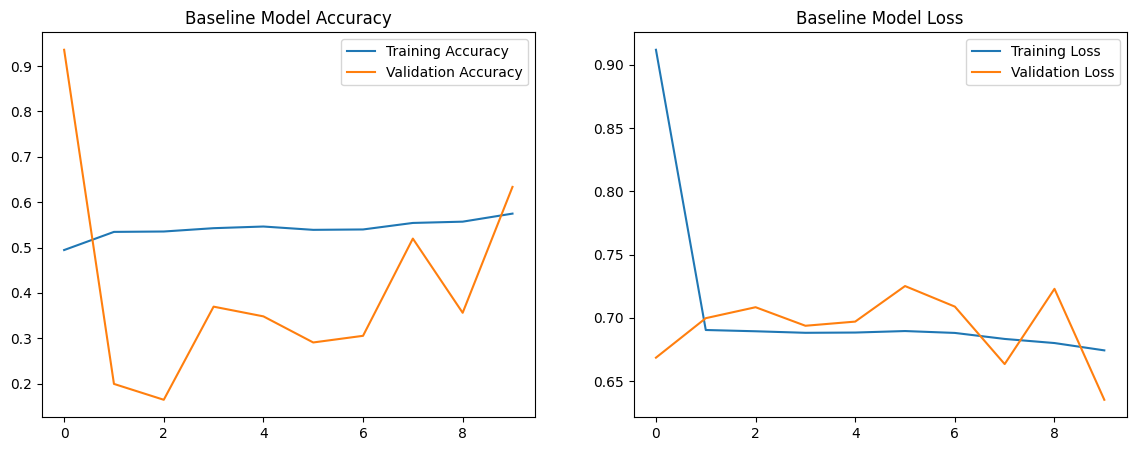

In [11]:
import matplotlib.pyplot as plt

acc = history_baseline.history['accuracy']
val_acc = history_baseline.history['val_accuracy']
loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Baseline Model Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Baseline Model Loss")
plt.show()


## **Classification Report and Confusion Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

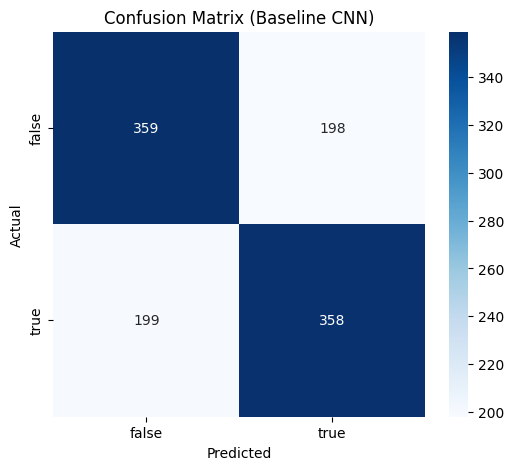

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# collect true labels + predictions
y_true = []
y_pred = []

for images, labels in test_ds_prep:
    preds = baseline_model.predict(images)
    preds = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

# report
print(classification_report(y_true, y_pred))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['false','true'],
            yticklabels=['false','true'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Baseline CNN)")
plt.show()

# **Transfer Learning: MobileNetV2**

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load pretrained base (without top classifier)
base_mnet = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"   # global average pooling
)

base_mnet.trainable = False  # feature extraction only

# Build full model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)      # MobileNetV2-specific normalization
x = base_mnet(x, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

mnet_model = tf.keras.Model(inputs, outputs, name="MobileNetV2_cardiomegaly")

mnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

mnet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_cardiomegaly"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
epochs_mnet = 10

history_mnet = mnet_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=epochs_mnet
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.5605 - loss: 0.7405 - val_accuracy: 0.5671 - val_loss: 0.6852
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5427 - loss: 0.7653 - val_accuracy: 0.6122 - val_loss: 0.6587
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5615 - loss: 0.7430 - val_accuracy: 0.6234 - val_loss: 0.6453
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5578 - loss: 0.7390 - val_accuracy: 0.6922 - val_loss: 0.5961
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5627 - loss: 0.7097 - val_accuracy: 0.6381 - val_loss: 0.6340
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5782 - loss: 0.7090 - val_accuracy: 0.6595 - val_loss: 0.6190
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5797 - loss: 0.7118 - val_accuracy: 0.7069 - val_loss: 0.5847
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5655 - loss: 0.7189 - val_accu

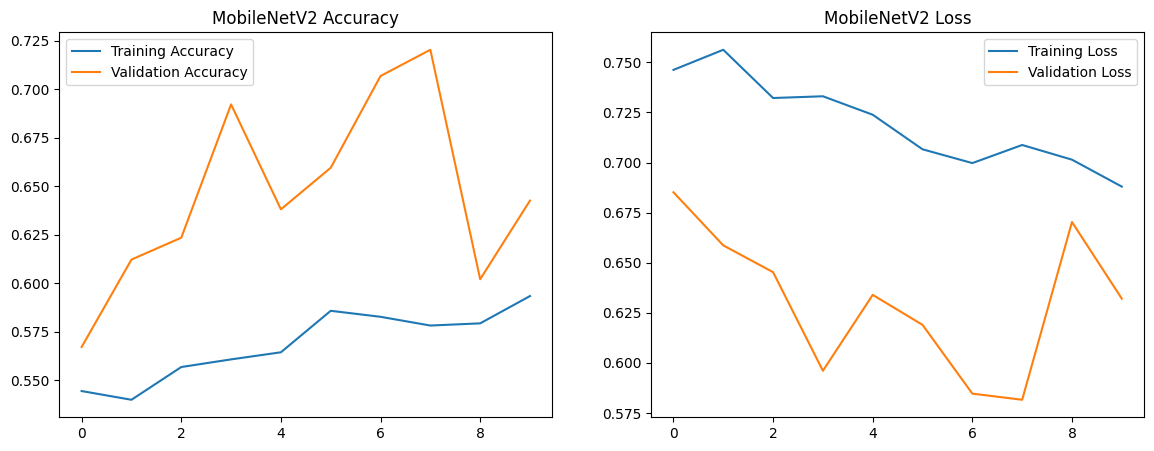

In [15]:
acc = history_mnet.history["accuracy"]
val_acc = history_mnet.history["val_accuracy"]
loss = history_mnet.history["loss"]
val_loss = history_mnet.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("MobileNetV2 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("MobileNetV2 Loss")
plt.legend()

plt.show()

MobileNetV2 Classification Report:

              precision    recall  f1-score   support

       false       0.64      0.61      0.62       557
        true       0.62      0.65      0.64       557

    accuracy                           0.63      1114
   macro avg       0.63      0.63      0.63      1114
weighted avg       0.63      0.63      0.63      1114



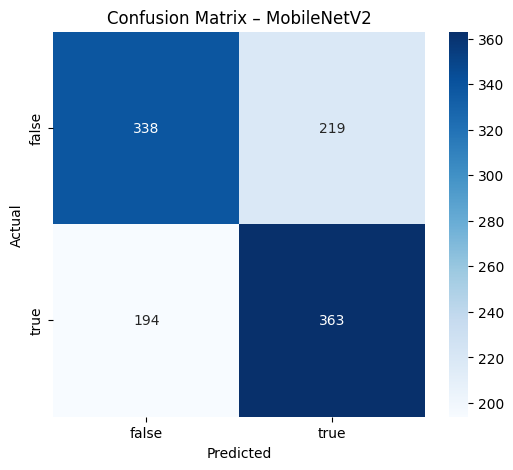

In [16]:
# Classification Report & Confusion Matrix (MobileNetV2)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true_mnet = []
y_pred_mnet = []

for images, labels in test_ds_prep:
    preds = mnet_model.predict(images, verbose=0)
    preds = (preds > 0.5).astype(int)
    y_true_mnet.extend(labels.numpy())
    y_pred_mnet.extend(preds.flatten())

print("MobileNetV2 Classification Report:\n")
print(classification_report(y_true_mnet, y_pred_mnet, target_names=["false", "true"]))

cm_mnet = confusion_matrix(y_true_mnet, y_pred_mnet)

plt.figure(figsize=(6,5))
sns.heatmap(cm_mnet, annot=True, fmt="d", cmap="Blues",
            xticklabels=["false", "true"],
            yticklabels=["false", "true"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – MobileNetV2")
plt.show()

# EfficientNetB3 Transfer Learning – Feature Extraction

In [17]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models

base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

eff_model = models.Model(inputs, outputs)

eff_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

eff_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,785,072 (41.14 MB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [18]:
history_eff = eff_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=10
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.5244 - loss: 0.7097 - val_accuracy: 0.8275 - val_loss: 0.5197
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.5956 - loss: 0.6663 - val_accuracy: 0.7632 - val_loss: 0.5711
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step - accuracy: 0.6375 - loss: 0.6410 - val_accuracy: 0.6584 - val_loss: 0.6309
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.6161 - loss: 0.6432 - val_accuracy: 0.8861 - val_loss: 0.4318
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.6340 - loss: 0.6395 - val_accuracy: 0.7001 - val_loss: 0.5901
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.6224 - loss: 0.6450 - val_accuracy: 0.8083 - val_loss: 0.5021
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.6564 - loss: 0.6157 - val_accuracy: 0.8726 - val_loss: 0.4453
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.6297 - loss: 0.6340 - val_accu

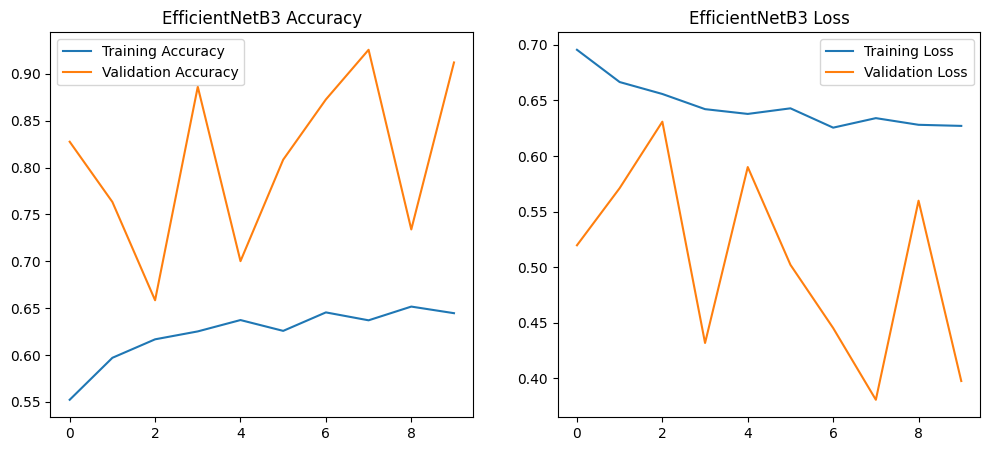

In [19]:
import matplotlib.pyplot as plt

epochs = range(len(history_eff.history["accuracy"]))

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, history_eff.history["accuracy"], label="Training Accuracy")
plt.plot(epochs, history_eff.history["val_accuracy"], label="Validation Accuracy")
plt.title("EfficientNetB3 Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, history_eff.history["loss"], label="Training Loss")
plt.plot(epochs, history_eff.history["val_loss"], label="Validation Loss")
plt.title("EfficientNetB3 Loss")
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

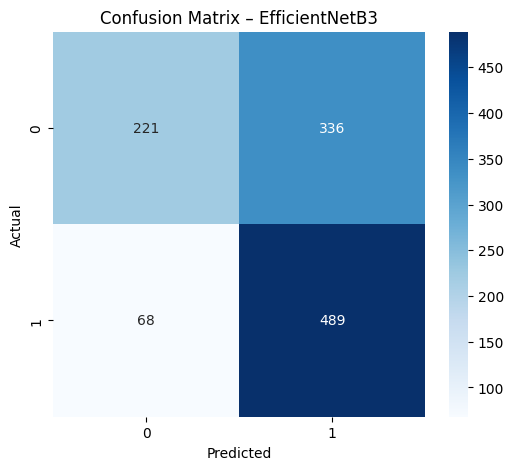

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_ds_prep:
    preds = eff_model.predict(images)
    preds = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print("EfficientNetB3 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["false", "true"]))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – EfficientNetB3")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()